In [29]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

In [3]:
STAD_mutation = pd.read_csv("/Users/shuhaoxu/Desktop/BNFO285/Groupproject/Project2/TCGA.STAD.mutations.txt", sep='\t')

In [13]:
mutation_matrix = pd.crosstab(
    index=STAD_mutation['patient_id'],
    columns=STAD_mutation['Hugo_Symbol'],
    values=1, 
    aggfunc='count'
)
mutation_matrix = mutation_matrix.fillna(0)

# random

In [21]:
reconstruction_errors = []
components_range = range(2, 30)

for n_components in components_range:
    model = NMF(n_components=n_components, init='random', random_state=42, max_iter=1000)
    W = model.fit_transform(mutation_matrix)
    H = model.components_
    
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(mutation_matrix - reconstructed)
    reconstruction_errors.append(error)

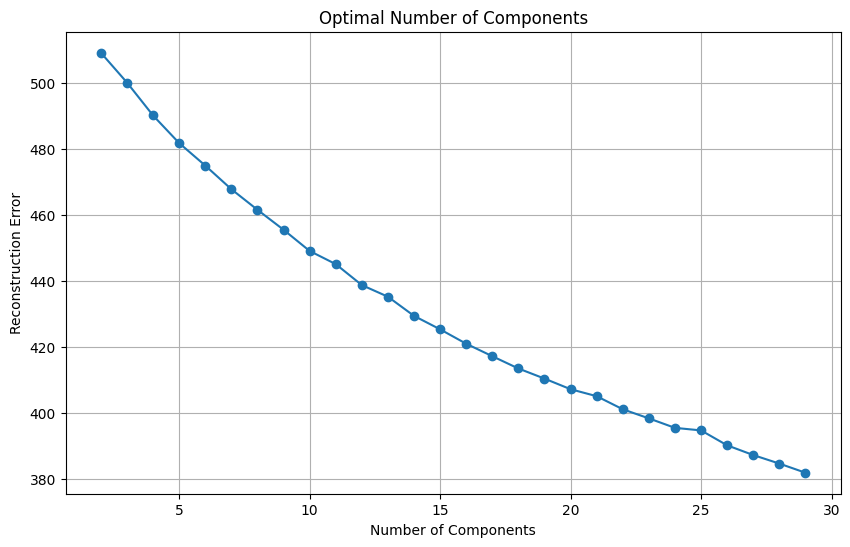

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Optimal Number of Components')
plt.grid(True)
plt.show()

# nndsvd

In [23]:
reconstruction_errors = []
components_range = range(2, 30)

for n_components in components_range:
    model = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=1000)
    W = model.fit_transform(mutation_matrix)
    H = model.components_
    
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(mutation_matrix - reconstructed)
    reconstruction_errors.append(error)

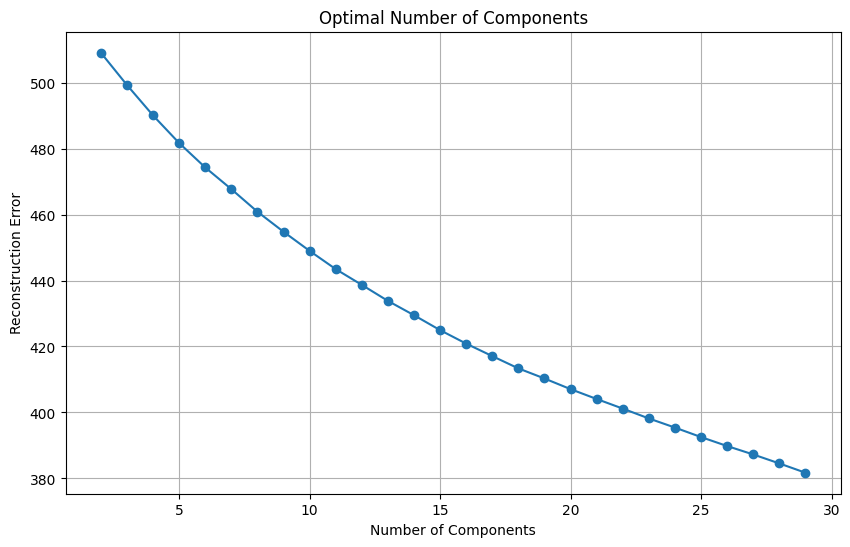

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Optimal Number of Components')
plt.grid(True)
plt.show()

# nndsvda

In [25]:
reconstruction_errors = []
components_range = range(2, 30)

for n_components in components_range:
    model = NMF(n_components=n_components, init='nndsvda', random_state=42, max_iter=1000)
    W = model.fit_transform(mutation_matrix)
    H = model.components_
    
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(mutation_matrix - reconstructed)
    reconstruction_errors.append(error)

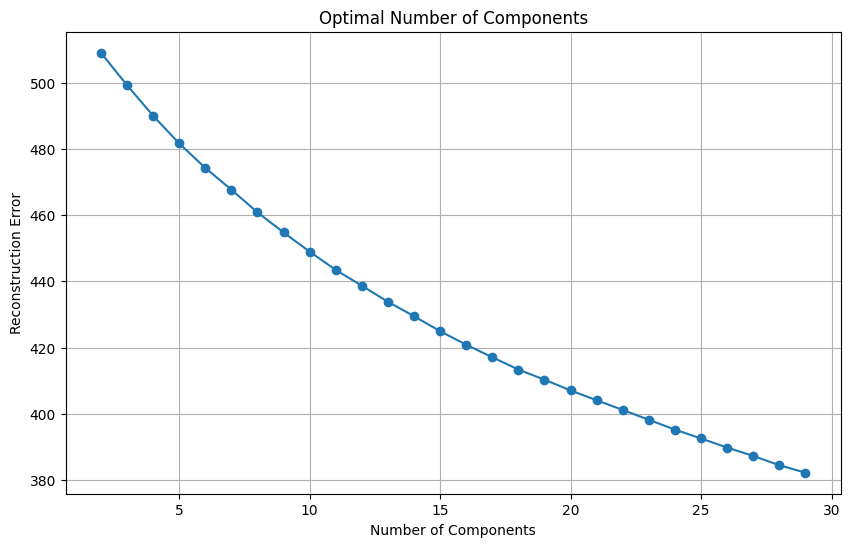

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Optimal Number of Components')
plt.grid(True)
plt.show()

# Test as many param as possible

In [36]:
def evaluate_nmf(data, components=5, init_method='random', 
                 beta_loss='frobenius', normalize_method=None):
    
    if normalize_method:
        if normalize_method == 'l1_sample':
            data_norm = normalize(data, norm='l1', axis=1)
        elif normalize_method == 'l2_sample':
            data_norm = normalize(data, norm='l2', axis=1)
        elif normalize_method == 'l1_gene':
            data_norm = normalize(data, norm='l1', axis=0)
        else:
            data_norm = data
    else:
        data_norm = data
    
    model = NMF(n_components=components, 
                init=init_method,
                beta_loss=beta_loss,
                random_state=0, 
                max_iter=2000,
                solver='mu')
    
    W = model.fit_transform(data_norm)
    H = model.components_
    reconstructed = np.dot(W, H)
    error = np.linalg.norm(data_norm - reconstructed)
    
    return {
        'error': error,
        'iterations': model.n_iter_,
        'W': W,
        'H': H,
        'model': model
    }

In [37]:
results = []
for init in ['random', 'nndsvd']:
    for beta in ['frobenius', 'kullback-leibler']:
        for norm in [None, 'l1_sample', 'l2_sample']:
            result = evaluate_nmf(mutation_matrix, 
                                  components=5,
                                  init_method=init,
                                  beta_loss=beta,
                                  normalize_method=norm)
            results.append({
                'init': init,
                'beta_loss': beta,
                'normalization': norm,
                'error': result['error'],
                'iterations': result['iterations']
            })
            
results_df = pd.DataFrame(results)

/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' o

In [38]:
results_df

,init,beta_loss,normalization,error,iterations
0,random,frobenius,None,481.807432,100
1,random,frobenius,l1_sample,1.828991,20
2,random,frobenius,l2_sample,19.560877,70
3,random,kullback-leibler,None,511.316652,130
4,random,kullback-leibler,l1_sample,2.349999,80
5,random,kullback-leibler,l2_sample,19.719020,110
6,nndsvd,frobenius,None,486.587470,40
7,nndsvd,frobenius,l1_sample,1.828991,20
8,nndsvd,frobenius,l2_sample,19.586669,30
9,nndsvd,kullback-leibler,None,515.505200,60


# Optimal parameters

In [42]:
optimal_components = 5
mutation_matrix_norm = normalize(mutation_matrix, norm='l1', axis=1)
final_model = NMF(n_components=optimal_components, init='nndsvd', beta_loss="frobenius", random_state=0, max_iter=2000)
W = final_model.fit_transform(mutation_matrix_norm)
H = final_model.components_
feature_importance = pd.DataFrame(H, columns=mutation_matrix.columns)

In [43]:
feature_importance

Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,hsa-mir-490,hsa-mir-6080,snoU13
0,3.200267e-09,4.789892e-09,1.400636e-07,2.628355e-07,2.666926e-10,1.257440e-10,2.523254e-10,6.661011e-08,6.648247e-08,1.693892e-10,...,2.412022e-09,1.058120e-09,6.723495e-08,2.839619e-09,3.900093e-10,6.232150e-09,1.463771e-09,1.093220e-09,3.250416e-07,8.361252e-11
1,3.291819e-06,3.228567e-06,1.069979e-05,5.904241e-06,6.190997e-07,1.191549e-06,2.179668e-06,2.455888e-06,3.294206e-06,1.981688e-06,...,3.742424e-06,2.160897e-06,5.340282e-06,3.503509e-06,2.507225e-07,3.370028e-05,1.503172e-06,8.517219e-07,1.758540e-06,3.126935e-08
2,5.467044e-07,1.359884e-06,3.911925e-06,2.661351e-05,4.304946e-07,2.306330e-07,3.745707e-08,5.999823e-07,1.623405e-06,4.597870e-07,...,6.931829e-07,1.807378e-06,1.226421e-05,5.875488e-07,9.793850e-07,3.107310e-06,5.378012e-07,2.513517e-07,3.497399e-07,1.222790e-08
3,7.892548e-05,1.163001e-04,2.617224e-04,1.596322e-04,7.094360e-06,3.109686e-06,7.978161e-06,3.036039e-05,8.814524e-05,3.730745e-06,...,1.296307e-04,2.860305e-05,5.802358e-05,7.363161e-05,1.056580e-05,1.982164e-04,4.585745e-05,3.768799e-05,3.475438e-05,2.114638e-06
4,3.362013e-05,1.242539e-04,1.985797e-04,1.066299e-04,5.118966e-06,1.212908e-06,5.859782e-06,1.248965e-05,6.800178e-05,2.062001e-06,...,2.714686e-05,3.895132e-05,1.393737e-04,2.880453e-05,8.558302e-06,7.619020e-05,1.958181e-05,1.673032e-05,1.765297e-05,2.251675e-06


# Preliminary

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

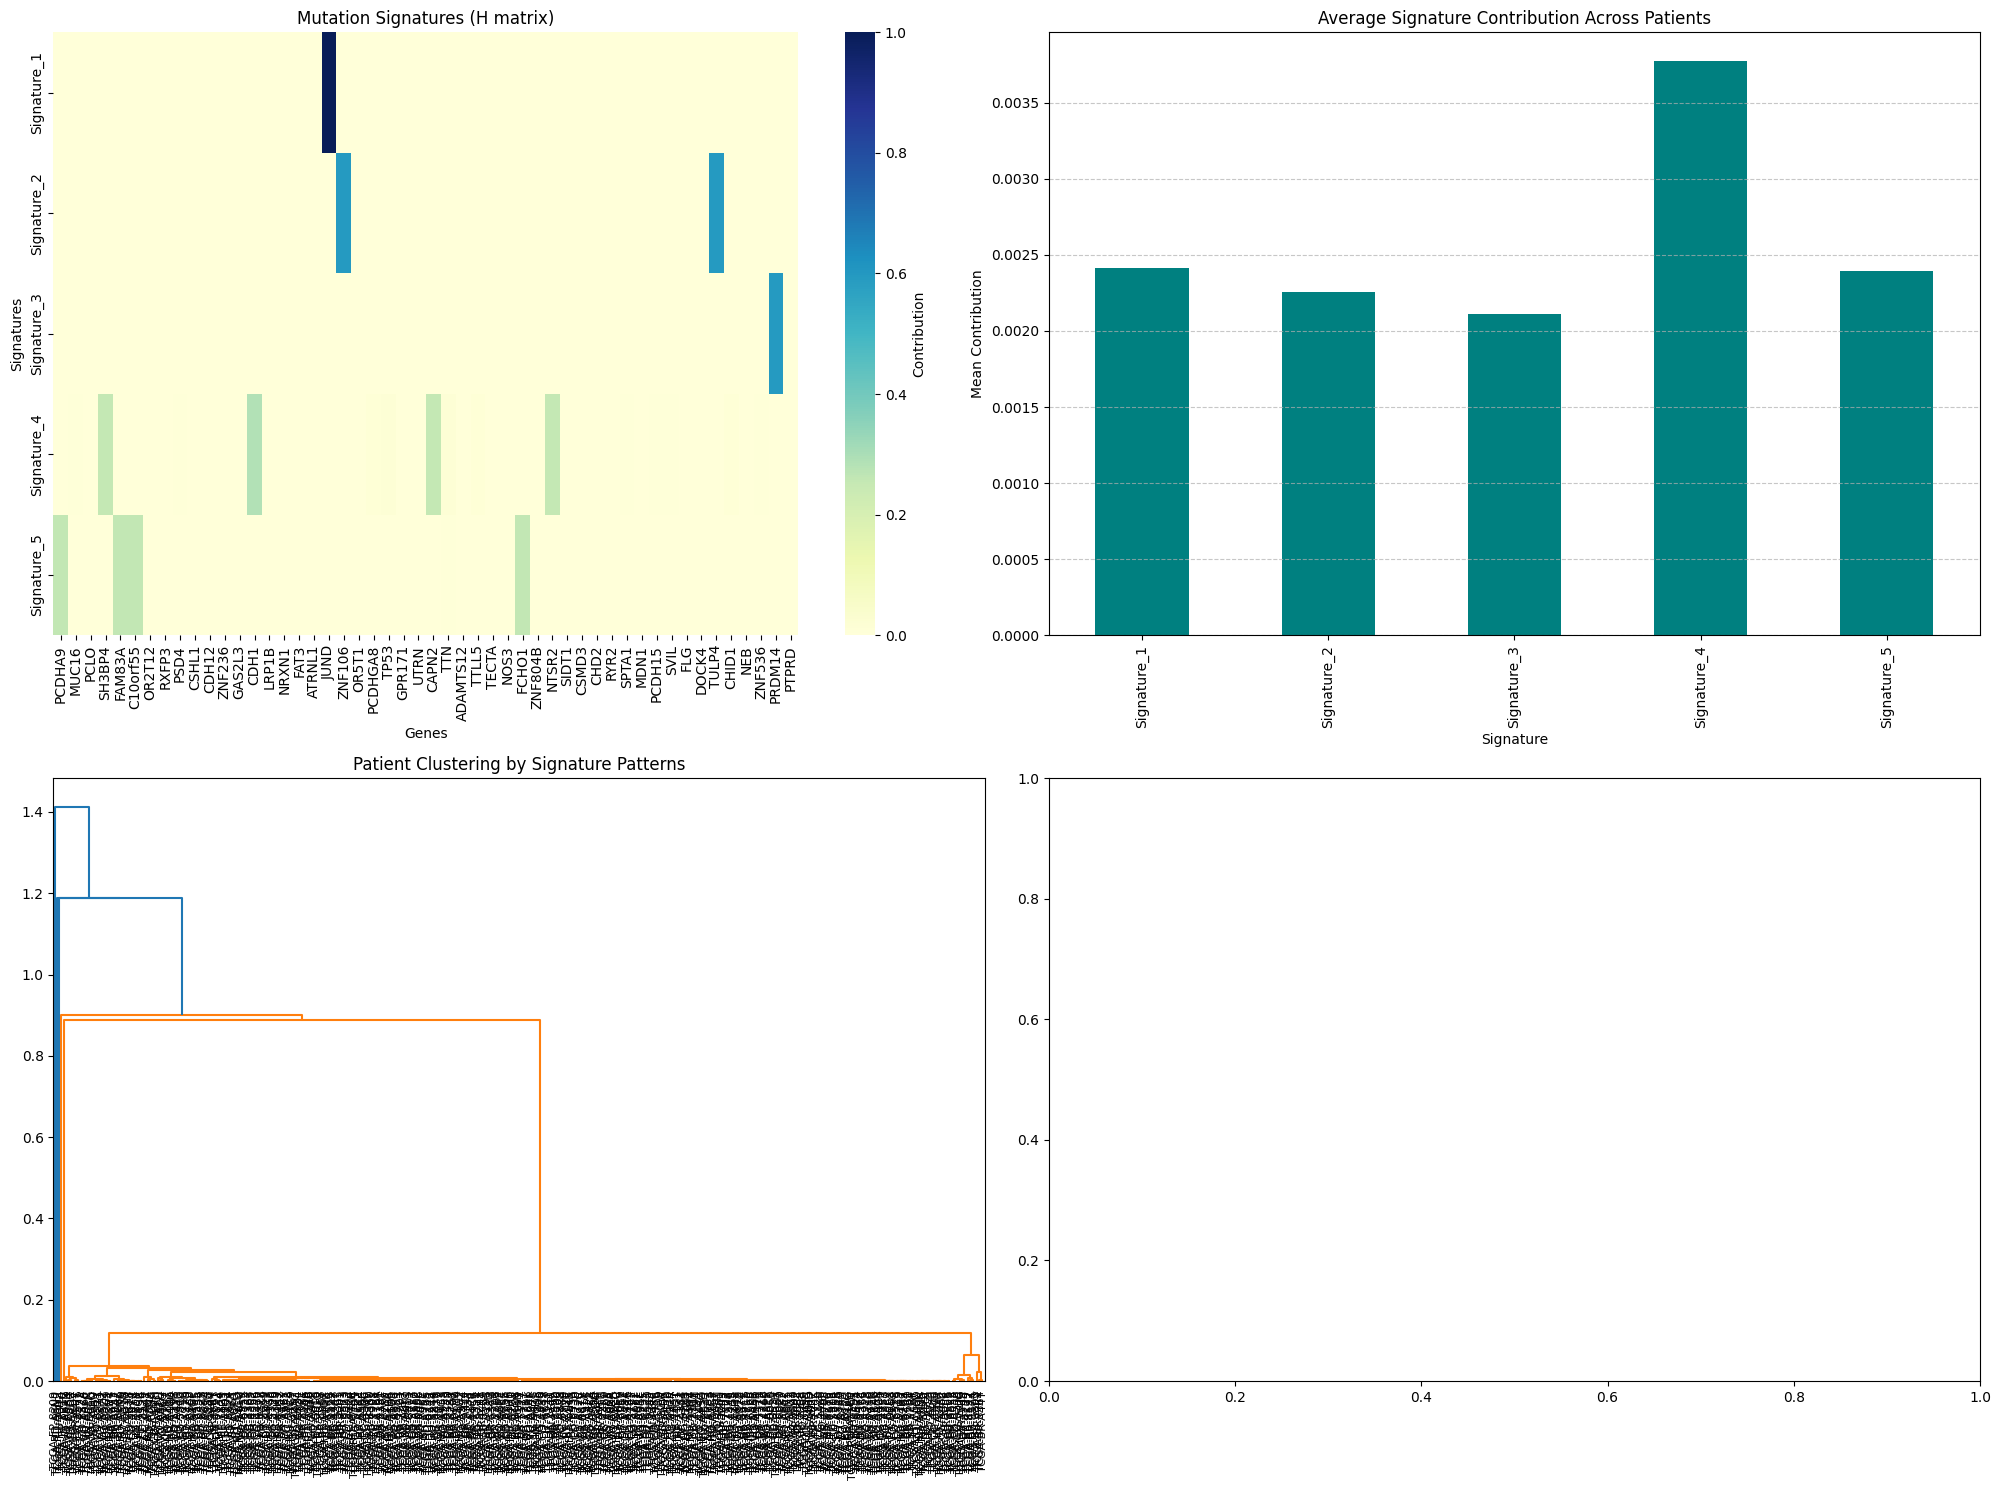

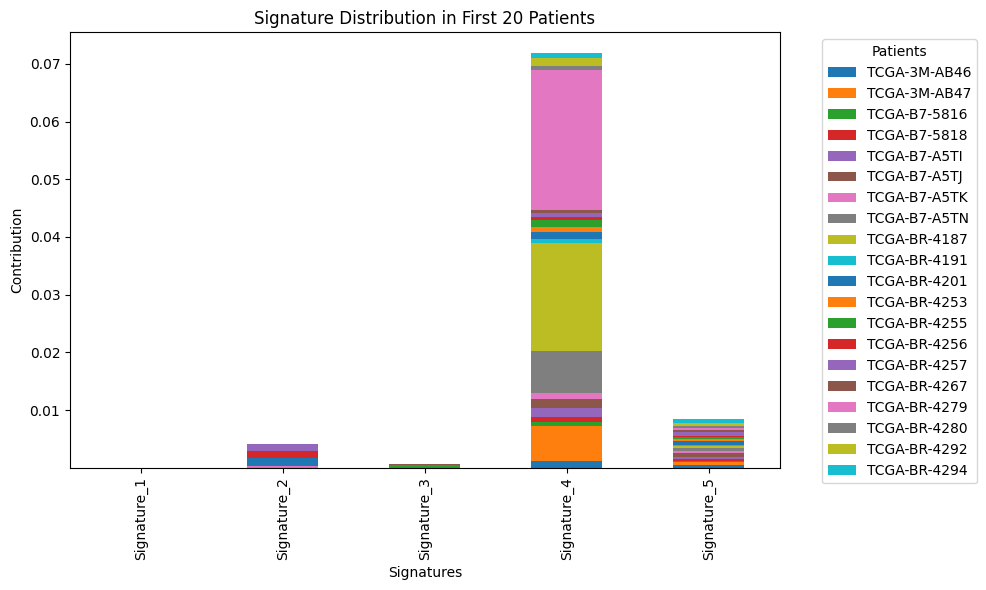

/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_71684/2256494083.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_gene_values.index[:15], y=top_gene_values.values[:15], palette="viridis")
/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_71684/2256494083.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_gene_values.index[:15], y=top_gene_values.values[:15], palette="viridis")
/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_71684/2256494083.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(

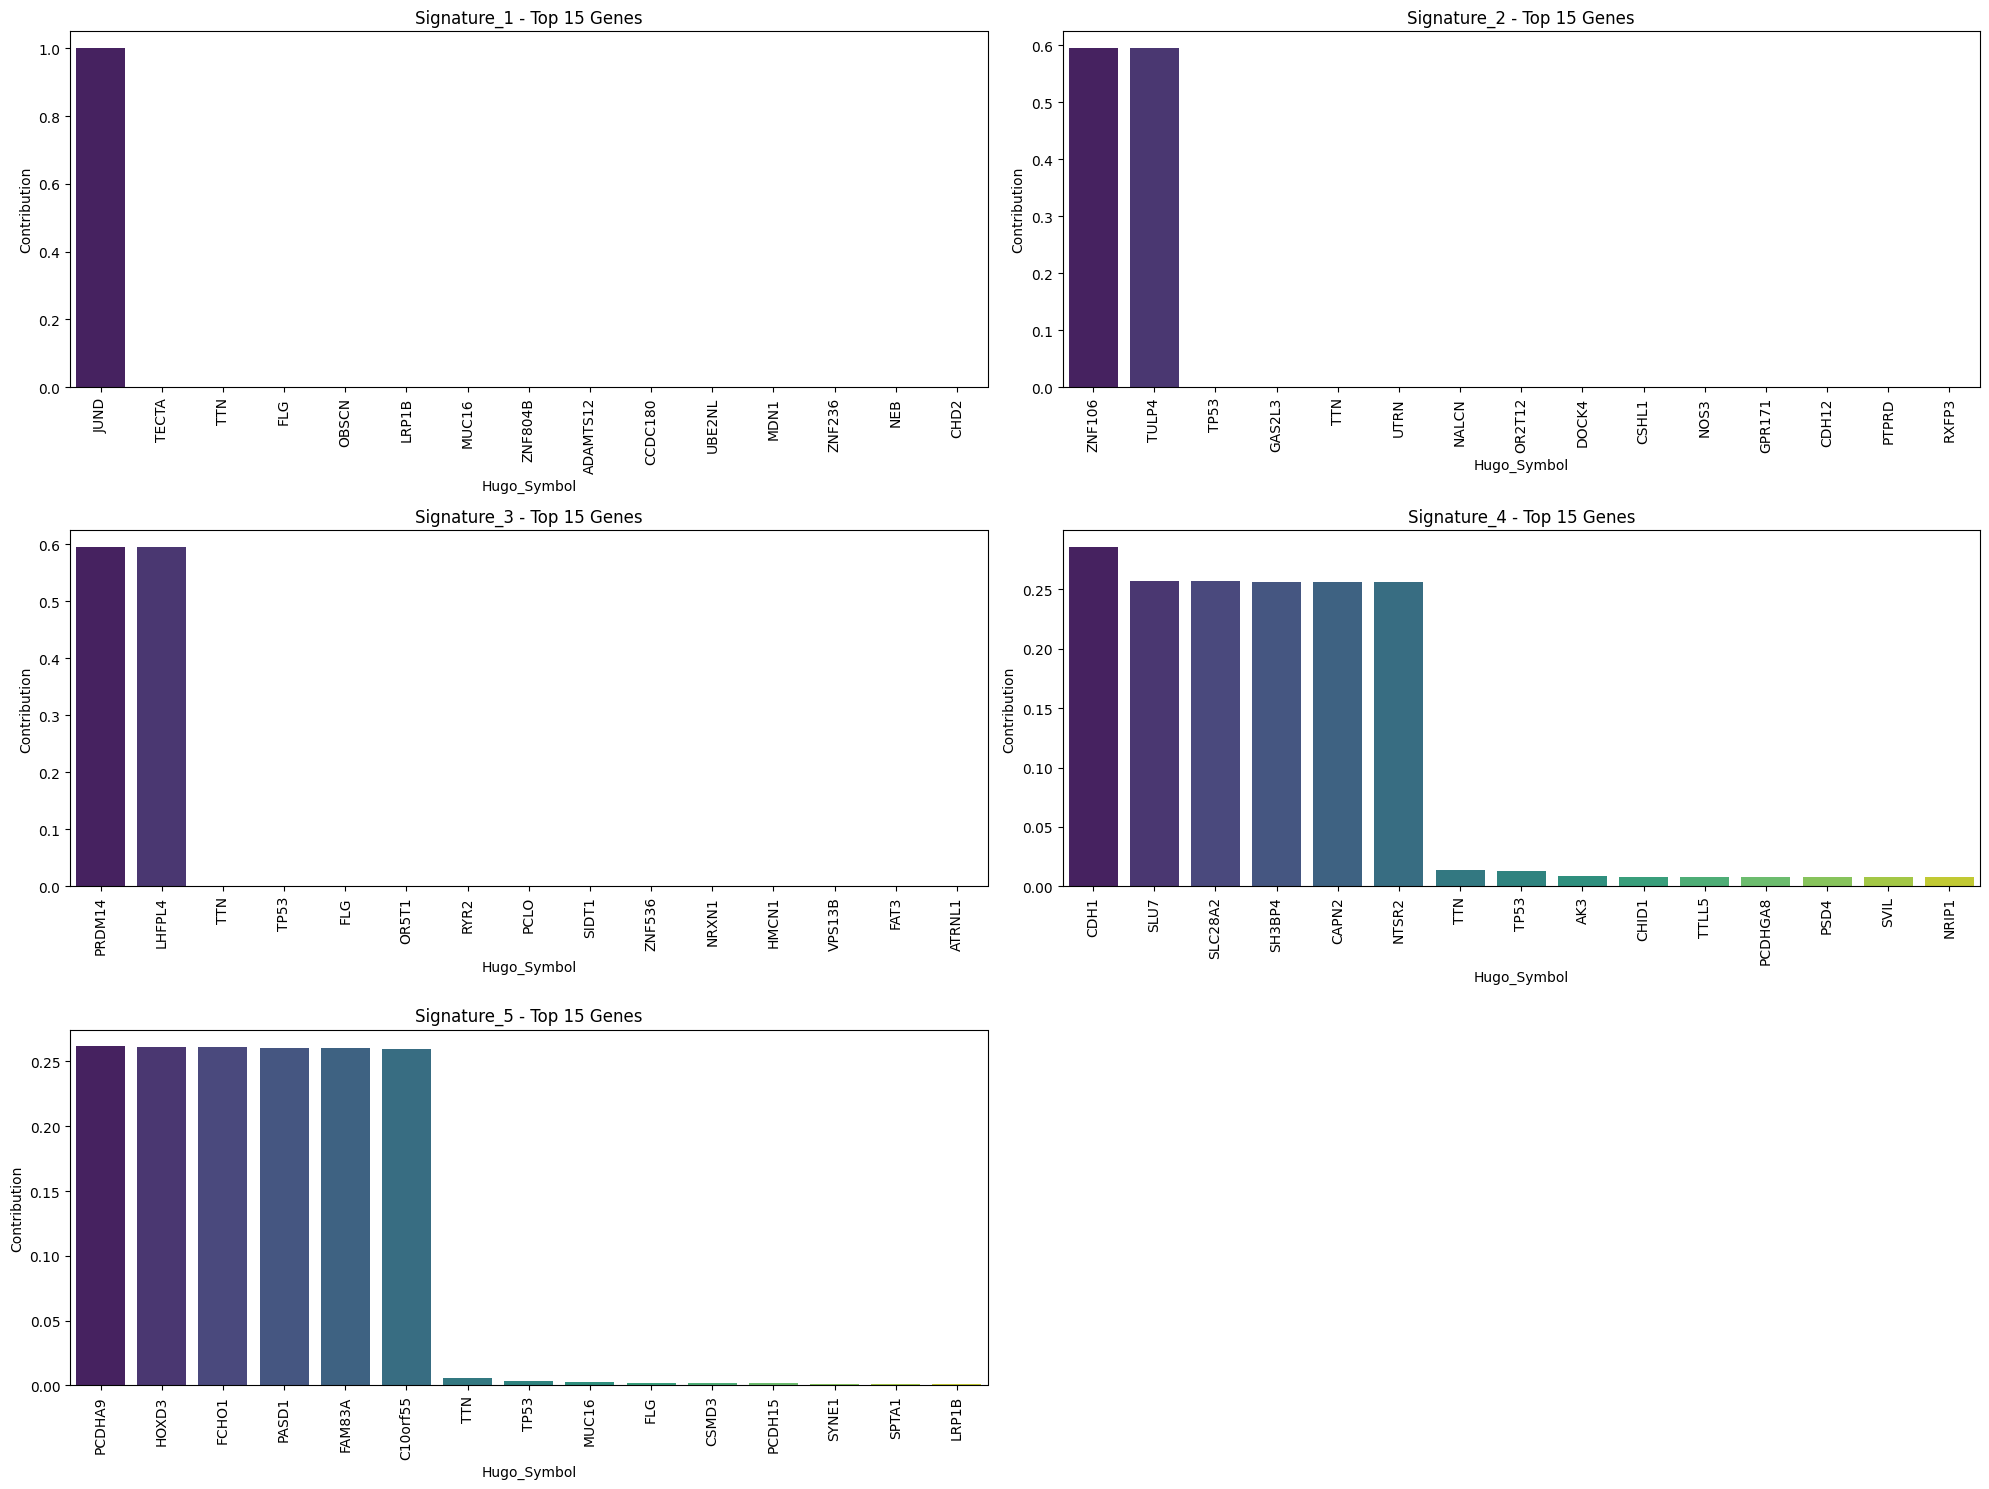

In [48]:
def analyze_signatures(H, mutation_matrix, top_n=20):
    signatures = pd.DataFrame(H, columns=mutation_matrix.columns)
    signatures.index = [f"Signature_{i+1}" for i in range(signatures.shape[0])]
    top_genes = {}
    for i, signature in enumerate(signatures.index):
        sorted_genes = signatures.iloc[i].sort_values(ascending=False)
        top_genes[signature] = sorted_genes.head(top_n)
    return signatures, top_genes

def analyze_patient_associations(W, mutation_matrix_norm, mutation_matrix):
    patient_signatures = pd.DataFrame(
        W, index=mutation_matrix.index,
        columns=[f"Signature_{i+1}" for i in range(W.shape[1])])
    
    patient_signatures['Dominant_Signature'] = patient_signatures.idxmax(axis=1)
    signature_counts = patient_signatures['Dominant_Signature'].value_counts()
    return patient_signatures

def visualize_nmf_results(signatures, patient_signatures, top_genes):
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    top_50_genes = set()
    for sig in signatures.index:
        top_50_genes.update(top_genes[sig].head(15).index)
    top_50_genes = list(top_50_genes)[:50]

    sns.heatmap(
        signatures[top_50_genes],
        cmap="YlGnBu",
        yticklabels=signatures.index,
        xticklabels=True,
        cbar_kws={"label": "Contribution"}
    )
    plt.title("Mutation Signatures (H matrix)")
    plt.xlabel("Genes")
    plt.ylabel("Signatures")
    plt.xticks(rotation=90)
    
    plt.subplot(2, 2, 2)
    sig_means = patient_signatures.drop('Dominant_Signature', axis=1).mean()
    sig_means.plot(kind='bar', color='teal')
    plt.title("Average Signature Contribution Across Patients")
    plt.xlabel("Signature")
    plt.ylabel("Mean Contribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 3)
    patient_sig_data = patient_signatures.drop('Dominant_Signature', axis=1)
    Z = linkage(patient_sig_data, 'ward')
    dendrogram(Z, labels=patient_sig_data.index, leaf_rotation=90, leaf_font_size=8)
    plt.title("Patient Clustering by Signature Patterns")
    plt.tight_layout()
    
    plt.subplot(2, 2, 4)
    patient_sig_data.iloc[:20].T.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title("Signature Distribution in First 20 Patients")
    plt.xlabel("Signatures")
    plt.ylabel("Contribution")
    plt.legend(title="Patients", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    # plt.savefig("nmf_mutation_signatures.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(20, 15))
    for i, sig in enumerate(signatures.index):
        plt.subplot(3, 2, i+1)
        top_gene_values = top_genes[sig].sort_values(ascending=False)
        sns.barplot(x=top_gene_values.index[:15], y=top_gene_values.values[:15], palette="viridis")
        plt.title(f"{sig} - Top 15 Genes")
        plt.xticks(rotation=90)
        plt.ylabel("Contribution")
    
    plt.tight_layout()
    # plt.savefig("signature_top_genes.png", dpi=300, bbox_inches='tight')
    plt.show()

def biological_interpretation(signatures, top_genes):
    signature_interpretations = {}

    for sig in signatures.index:
        signature_interpretations[sig] = {
            'top_genes': list(top_genes[sig].head(10).index),
            'potential_pathways': [],
            'biological_processes': [],
            'similar_known_signatures': [],
            'notes': ''
        }
    return signature_interpretations


signatures, top_genes = analyze_signatures(H, mutation_matrix)
patient_signatures = analyze_patient_associations(W, mutation_matrix_norm, mutation_matrix)
visualize_nmf_results(signatures, patient_signatures, top_genes)
signature_interpretations = biological_interpretation(signatures, top_genes)

results =  {
        'signatures': signatures,
        'patient_signatures': patient_signatures,
        'top_genes': top_genes,
        'interpretations': signature_interpretations
    }